In [ ]:
#Parte 1
#Procesamiento de Imágenes

#Paquete inicial

In [ ]:
!pip install -U --pre tensorflow=="2.2.0"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement tensorflow==2.2.0 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.13.0rc0, 2.13.0rc1)
ERROR: No matching distribution found for tensorflow==2.2.0


In [ ]:
import numpy as np
np.__version__

'1.22.4'

In [ ]:
pip install -U numpy=="1.23.5"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [ ]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/models/research
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1696986 sha256=6e43db0955b4dff56b74a6c821ff144c734a3ec1ebd1d1c4bef8b48a86c728d3
  Stored in directory: /tmp/pip-ephem-wheel-cache-sj_j9206/wheels/53/dd/70/2de274d6c443c69d367bd6a5606f95e5a6df61aacf1435ec0d
Successfully built object-detection
  Attempting uninstall: object-detection
    Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import cv2
import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage
import PIL.ImageOps
import tensorflow as tf

# from object_detection.utils import label_map_util
# from object_detection.utils import config_util
# from object_detection.utils import visualization_utils as viz_utils
# from object_detection.utils import colab_utils
# from object_detection.builders import model_builder

%matplotlib inline

# Cargar los datos CSV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# cargar csv Original
import pandas as pd
from os import path

train_path = path.join('/content/drive/MyDrive/Trabajo_final_VIU/Resources/Annotations','train.csv')
train_csv = pd.read_csv(train_path)
# print(train_csv)

In [ ]:
# Edit CVS para nuestra conveniencia
# Identificar solo osteophytos
csv_final = train_csv.copy()
csv_final = csv_final.loc[:,['image_id','lesion_type','xmin','ymin','xmax','ymax']]
csv_final=csv_final[csv_final["lesion_type"]=="Osteophytes"]
train_list=csv_final["image_id"].unique()
csv_final.reset_index(drop=True, inplace=True)
display(len(train_list))
#display(train_list)
save_path = path.join('/content/drive/MyDrive/Trabajo_final_VIU/Resources/Annotations','TFM_train.csv')
pd.DataFrame(csv_final).to_csv(save_path)

3575

In [ ]:
# cargar csv Test
import pandas as pd
from os import path

test_path = path.join('/content/drive/MyDrive/Trabajo_final_VIU/Resources/Annotations','test.csv')
test_csv = pd.read_csv(test_path)
# print(test_csv)

In [ ]:
# Edit CVS para nuestra conveniencia
# Identificar solo osteophytos
csv_final = test_csv.copy()
csv_final = csv_final.loc[:,['image_id','lesion_type','xmin','ymin','xmax','ymax']]
csv_final=csv_final[csv_final["lesion_type"]=="Osteophytes"]
csv_final.reset_index(drop=True, inplace=True)
test_list=csv_final["image_id"].unique()
# display(csv_final)
# display(csv_final)
display(len(test_list))
save_path = path.join('/content/drive/MyDrive/Trabajo_final_VIU/Resources/Annotations','TFM_test.csv')
pd.DataFrame(csv_final).to_csv(save_path)

878

# Cargar Imagen

In [ ]:
BadList=[51,53,54,150,170,181,186,228,232,250,268,270,274,284,
         535,533,522,493,475,467,424,423,411,311,319,
         1144,1111,1117,1102,1092,1093,1072,1071,1067,1068,1039,
         1027,1011,982,978,960,934,927,924,925,
         910,912,911,915,913,914,896,876,875,867,
         858,864,847,827,815,814,816,812,811,809,
         805,806,801,770,771,768,769,767,766,
         761,762,764,765,760,759,733,734,735,
         678,682,684,671,608,607,602,585,586,560,1234,1240,1242,1291,1289,1285,
         1297,1302,1305,1301,1303,1304,1314,1311,1315,1317,1312,1320,1318,1319,1322
         ,1323,1347,1348,1351,1363,1352,1361,1370,1372,1366,1404,1413,1424,1429,1444
         ,1442,1464,1488,1487,1494,1512,1513,1514,1515,1518,1520,1555,1598,1599,1601
         ,1618,1630,1632,1635,1641,1639,1640,1650,1646,1648,1658,1657,1672,1670,1668,
         1710,1784,1815,1868,1883,1902,1919,1929,1941,1950,1983,1989,1993,1991,1994,1997
         ,1999,2000,2004,2008,2006,2013,2012,2014,2041,2173,2244,2251,2280,2275,2278,2301
         ,2307,2305,2315,2348,2347,2343,2391,2488,2487,2486,2491,2493,2490,2503,2505,2519
         ,2523,2522,2540,2577,2594,2600,2622,2654,2653,2655,2652,2669,2666,2657,2665,2662,2680
         ,2681,2679,2683,2684,2682,2686,2724,2729,2725,2732,2736,2734,2735,2737,2757,2770,2765
         ,2766,2810,2809,2813,2817,2815,2842,2840,2844,2879,2890,2889,2894,2955,2963,2964,2970,
         2978,2972,2969,2983,2991,2993,2996,3000,3008,3030,3091,3084,3083,3086,3087,3130,3164,
         3167,3163,3169,3171,3168,3173,3170,3175,3181,3183,3200,3202,3212,3260,3266,3277,3280,
         3282,3288,3284,3291,3290,3324,3330,3381,3395,3455,3463,3472,3494,3583,3603,3605,3655,
         3654,3663,3692,3694,3695,3758,3762,3757,3763,3760,3764,3765,3784,3783,3780,3787,3788,
         3790,3797,3798,3805,3804,3824,3892,3921,3925,3927,3928,3963,3979,4011,4002,4005,4008,
         4022,4046,4054,4066,4064,4062,4063,4059,4061,4067,4104,4117,4122,4135,4131,4130,4137,4188,
         4189,4190,4194,4262,4284,4292,4291,4294,4297,4308,4299,4296,4363,4364,4378,4387,4402,4398,
         4400,4401,4449,4444,4443,4522,4524,4527,4525,4532,4529,4537,4546,4547,4570,4613,4632,4627,
         4625,4626,4664,4659,4671,4695,4698,4693,4715,4720,4725,4733,4743,4749,4742,4771,4775,4779,4867,
         4917,4943,4942,4949,4951,4991,4996,4995,5022,5041,5043,5032,5038,5053,5057,5059,5086,5088,5089,
         5090,5093,5096,5092,5177,5193,5198,5201,5264,5270,5275,5283,5304,5305,5303,5306,5309,5311,5312,
         5310,5317,5314,5315,5313,5318,5320,5325,5338,5343,5341,5342,5358,5364,5397,5409,5416,5415,5420,
         5425,5427,5422,5471,5494,5495,5498,5499,5508,5510,5516,5525,5528,5565,5573,5600,5601,5609,5636,
         5635,5639,5643,5640,5648,5646,5656,5657,5658,5654,5665,5676,5671,5667,5686,5682,5710,5711,5707,
         5712,5713,5714,5724,5720,5721,5742,5756,5759,5784,5782,5783,5804,5835,5847,5878,5886,5887,5971,5966,5994,6000]

In [ ]:
# Creacion Data Frame
cortes_train = pd.DataFrame(columns=['Nom_Img', 'Nom_Train', 'Width_Img','Heigt_Img','LineH','LineV'],index=range(1020))
cortes_train.shape

(1020, 6)

In [ ]:
# Leer el Data Frame
from os import path
read_path = path.join('/content/drive/MyDrive/Trabajo_final_VIU/Resources/Annotations','TFM_cortes.csv')
cortes_train = pd.read_csv(read_path, index_col=[0])

In [ ]:
def Cargar_imagen(Num_img):
  Train_image_dir = '/content/drive/MyDrive/Trabajo_final_VIU/Resources/Train_Images'
  print("Imagen de nombre: "+train_list[Num_img])
  img=cv2.imread(os.path.join(Train_image_dir, train_list[Num_img]+'.jpg'))
  img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  imagen_id=train_list[Num_img]
  mask=(train_csv["image_id"]==imagen_id)
  df=train_csv[mask]
  return(img,imagen_id,df)

In [ ]:
def Graficar(img,df,LineH,LineV,opc):

  # Imagen Principal
  plt.clf()
  fig, ax = plt.subplots()
  final_image = Image.fromarray(img)
  # Impresión con escala para mejor visualizacion
  fig.set_size_inches(20, 20, forward=True)
  ax.imshow(final_image, cmap='gray', vmin=0, vmax=255)
  #
  #dibujar puntos de enfermedad
  for i in df.index:
      # Create a Rectangle patch
      Width= int(df["xmax"][i]-df["xmin"][i])
      Height=int(df["ymax"][i]-df["ymin"][i])
#     Ver Imagen con Restricciones
      if (opc==1):
        if not(i in BadList):
          rect = patches.Rectangle((int(df["xmin"][i]), int(df["ymin"][i])), Width, Height, linewidth=2, edgecolor='r', facecolor='none')
          plt.text(int(df["xmin"][i]), int(df["ymin"][i]),str(i))
          ax.add_patch(rect)
      else:
        # Ver imagen normal sin restricciones
        rect = patches.Rectangle((int(df["xmin"][i]), int(df["ymin"][i])), Width, Height, linewidth=2, edgecolor='r', facecolor='none')
        plt.text(int(df["xmin"][i]), int(df["ymin"][i]),str(i))
        ax.add_patch(rect)

  if (opc!=2):
    print("Por aqui pase")
    #Lineas de Corte
    for n in LineH:
      plt.axhline(y=n, color="g")
    for n in LineV:
      plt.axvline(x=n, color="g")

  plt.show()

In [ ]:
def Creacion_Lineas(Num_img,img,df,Stdar):
  img_height,img_width=np.array(img).shape[0],np.array(img).shape[1]
  NLineasy=img_height//Stdar
  Nlineasx=img_width//Stdar
  LineH=[0]

  for n in range(1,NLineasy+1):
    LineH.append(n*640)
  n=0
  while (n<(len(LineH))):
    for i in df.index:
      if((df["ymin"][i]<=LineH[n])and(LineH[n]<=df["ymax"][i])) and not(i in BadList):
        LineH[n]=int(df["ymin"][i])-5
        for j in range(n+1,len(LineH)):
          LineH[j]=LineH[j-1]+640
        n=n-1
      if(img_height-LineH[-1]>640):
        LineH.append(LineH[-1]+640)
    n+=1
  if(LineH[-1]!=img_height-1):
    LineH.append(img_height-1)



  LineV=[0]
  for n in range(1,Nlineasx+1):
    LineV.append(n*640)

  n=0
  while (n<(len(LineV))):
    for i in df.index:
      if((df["xmin"][i]<=LineV[n])and(LineV[n]<=df["xmax"][i]))and not(i in BadList):
        LineV[n]=int(df["xmin"][i])-2
        for j in range(n+1,len(LineV)):
          LineV[j]=LineV[j-1]+640
        n=n-1
    if(img_width-LineV[-1]>640):
      LineV.append(LineV[-1]+640)
    n+=1
  if(LineV[-1]!=img_width-1):
    LineV.append(img_width-1)


  # Añadir al cvs
  cortes_train.loc[Num_img] = [train_list[Num_img],'imagen'+str(Num_img),img_width,img_height,LineH,LineV]
  # print(cortes_train.loc[Num_img])
  save_path = path.join('/content/drive/MyDrive/Trabajo_final_VIU/Resources/Annotations','TFM_cortes.csv')
  pd.DataFrame(cortes_train).to_csv(save_path)
  # display(cortes_train)
  # display(cortes_train.columns)

  return(LineH,LineV)

Imagen de nombre: 1f1c5c098c35b79052596aae08ac727f
Por aqui pase


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


<Figure size 640x480 with 0 Axes>

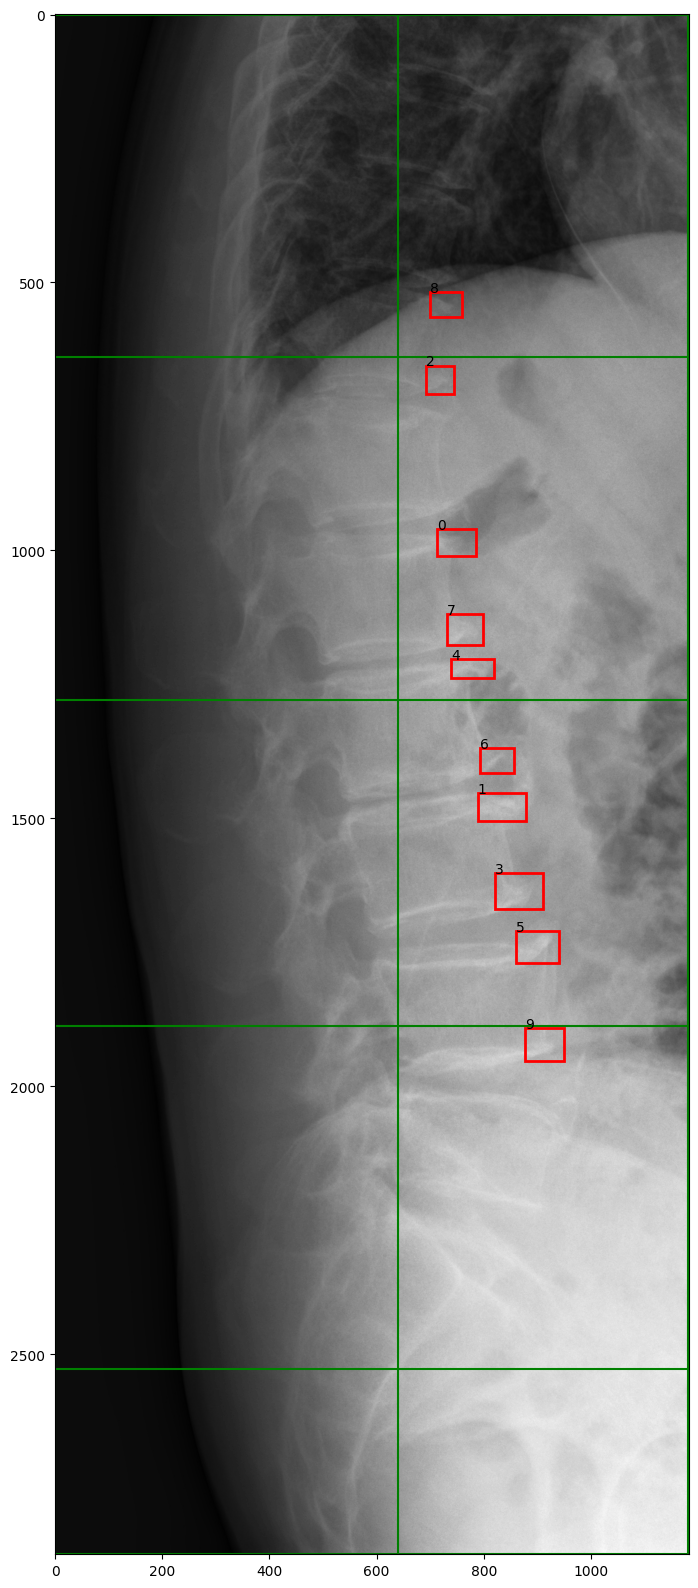

Por aqui pase


<Figure size 640x480 with 0 Axes>

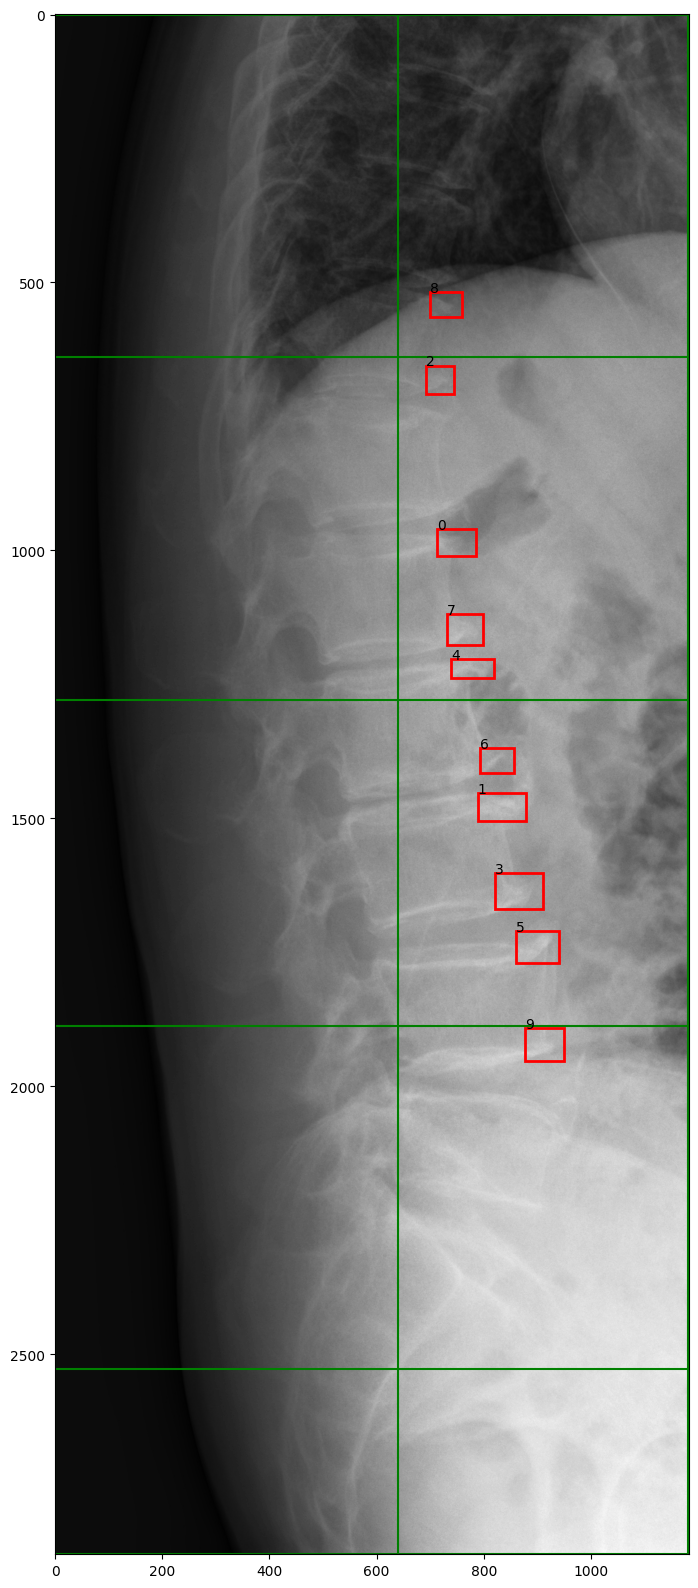

<Figure size 640x480 with 0 Axes>

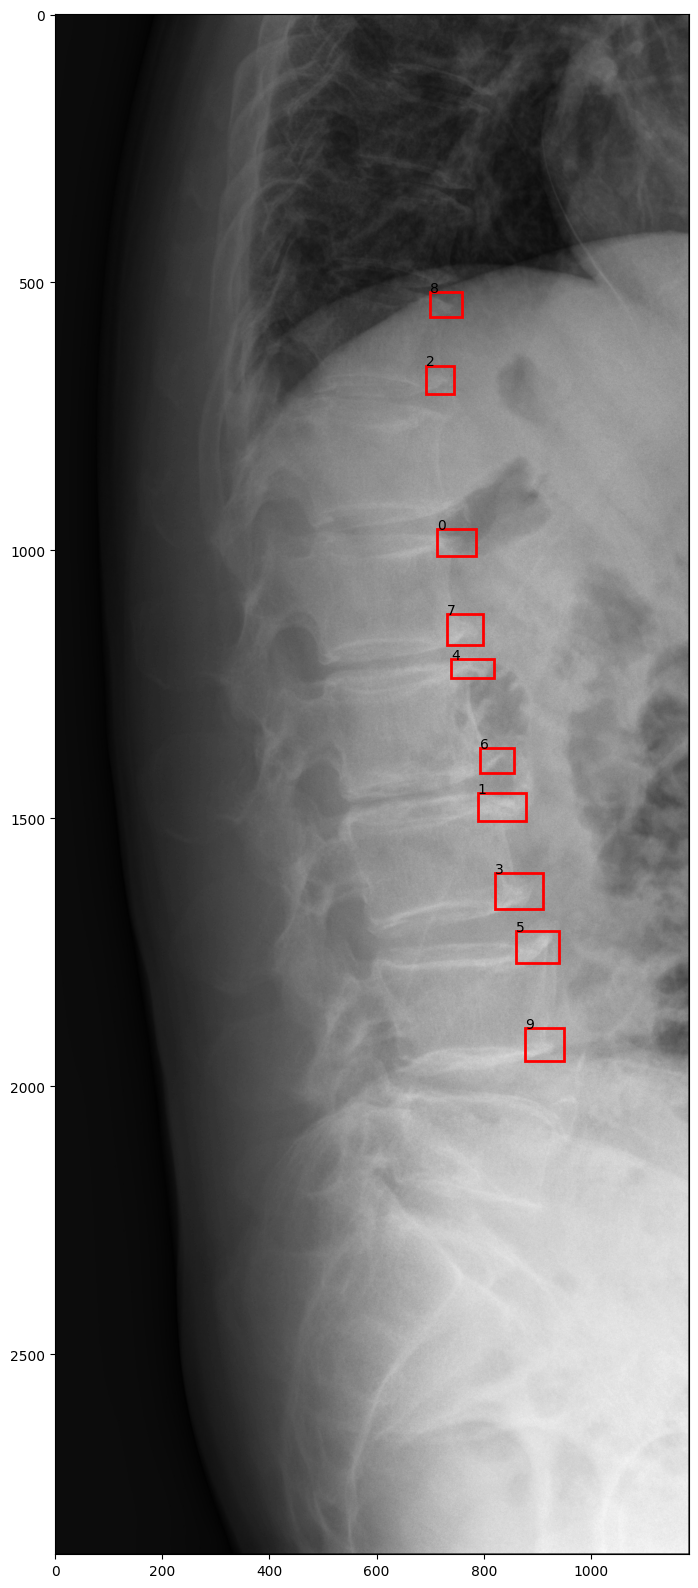

In [ ]:
# generar imagen y recortes
import matplotlib.patches as patches
import matplotlib.pylab as plt
from PIL import Image
#sacar las cajas de la imagen
for Num_img in range(0,1):
  img,imagen_id,df = Cargar_imagen(Num_img)
  LineH,LineV = Creacion_Lineas(Num_img,img,df,640)
  Graficar(img,df,LineH,LineV,0)
  Graficar(img,df,LineH,LineV,1)  #df son los puntos que nos entrega el Csv original: 0 para ver todos los puntos; 1 para ver solo los puntos correctos(Sin errores)
  Graficar(img,df,LineH,LineV,2)  #Solo grafica la imagenes y las detecciones.

In [ ]:
# Leer el Data Frame
read_path = path.join('/content/drive/MyDrive/Trabajo_final_VIU/Resources/Annotations','TFM_cortes.csv')
cortes_train = pd.read_csv(read_path, index_col=[0])
print(cortes_train.columns)

Index(['Nom_Img', 'Nom_Train', 'Width_Img', 'Heigt_Img', 'LineH', 'LineV'], dtype='object')


In [ ]:
# Recorte de Imagenes y Creacion de Train
# Crop
# #sacar las cajas de la imagen
def Crop_img (Num_img,img,df,LineH,LineV):
  global contar
  h=0
  cont=1
  while (h<(len(LineH)-1)):
    v=0
    while (v<(len(LineV)-1)):
      y1=int(LineH[h])
      y2=int(LineH[h+1])
      x1=int(LineV[v])
      x2=int(LineV[v+1])
      Imagen2=[]
      Aux=""
      path = "/content/drive/MyDrive/Trabajo_final_VIU/Resources/Train_"+str(contar//500)+"/"+"labels/"
      isExist = os.path.exists(path)
      if not isExist:
        os.makedirs(path)

      for i in df.index:
        Xcenter=int((df["xmax"][i]+df["xmin"][i])/(2))
        Ycenter=int((df["ymax"][i]+df["ymin"][i])/(2))
        Width= int(df["xmax"][i]-df["xmin"][i])
        Height=int(df["ymax"][i]-df["ymin"][i])
        if(((y1<=Ycenter)and(Ycenter<=y2)) and ((x1<=Xcenter)and(Xcenter<=x2))):
          if not(i in BadList):
            Aux=Aux+str("0"+" "+str((Xcenter-x1)/(x2-x1))+" "+str((Ycenter-y1)/(y2-y1))+" "+str(Width/(x2-x1))+" "+str(Height/(y2-y1))+ "\n")
      #Impresión en TXT
      path="/content/drive/MyDrive/Trabajo_final_VIU/Resources/Train_"+str(contar//500)+"/"+"labels/"
      isExist = os.path.exists(path)
      if not isExist:
        os.makedirs(path)
      with open(path+"imagen"+str(Num_img)+"-"+str(cont)+".txt", 'w') as txt_file:
         txt_file.write(str(Aux))
      Imagen2 = img[y1:y2,x1:x2]
      path="/content/drive/MyDrive/Trabajo_final_VIU/Resources/Train_"+str(contar//500)+"/"+"images/"
      isExist = os.path.exists(path)
      if not isExist:
        os.makedirs(path)
      destination= path +"imagen"+str(Num_img)+"-"+str(cont)+'.jpg'
      cv2.imwrite(destination, Imagen2)
      contar+=1
      cont+=1
      v+=1
    h+=1


Imagen de nombre: 1f1c5c098c35b79052596aae08ac727f
Por aqui pase


<Figure size 640x480 with 0 Axes>

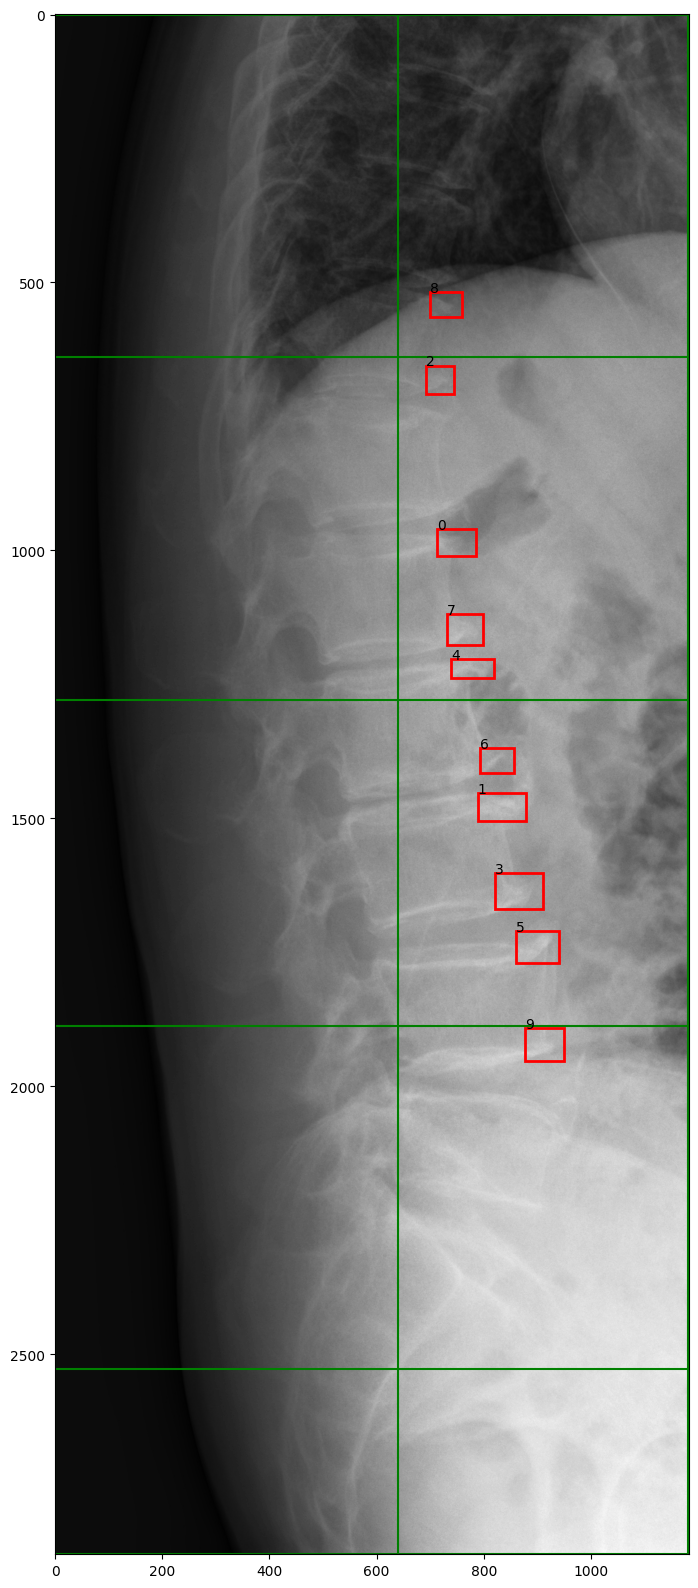

In [ ]:
#Crop de las imagenes
LineHcsv=np.array(cortes_train["LineH"])
LineVcsv=np.array(cortes_train["LineV"])
contar=0

for Num_img in range(0,1):
  img,imagen_id,df = Cargar_imagen(Num_img)
  Graficar(img,df,LineH,LineV,1)  #df son los puntos que nos entrega el Csv original: 0 para ver todos los puntos; 1 para ver solo los puntos correctos
  LineH=LineHcsv[Num_img][1:-1].split(", ")
  LineV=LineVcsv[Num_img][1:-1].split(", ")
  Crop_img(Num_img,img,df,LineH,LineV)


#Crop de imagenes solo entrenamiento


In [ ]:
# Recorte de Imagenes y Creacion de Train
# Crop
# #sacar las cajas de la imagen
def Crop_img2 (Num_img,img,df,LineH,LineV):
  # print("Imagen "+str(Num_img))
  # print(LineH)
  # print(LineV)
  global contar
  h=0
  cont=1
  while (h<(len(LineH)-1)):
    v=0
    while (v<(len(LineV)-1)):
      y1=int(LineH[h])
      y2=int(LineH[h+1])
      x1=int(LineV[v])
      x2=int(LineV[v+1])
      # print(str(y1)+" "+str(y2)+" "+str(x1)+" "+str(x2))
      Imagen2=[]
      Aux=""

      for i in df.index:
        Xcenter=int((df["xmax"][i]+df["xmin"][i])/(2))
        Ycenter=int((df["ymax"][i]+df["ymin"][i])/(2))
        Width= int(df["xmax"][i]-df["xmin"][i])
        Height=int(df["ymax"][i]-df["ymin"][i])
        if(((y1<=Ycenter)and(Ycenter<=y2)) and ((x1<=Xcenter)and(Xcenter<=x2))):
          if not(i in BadList):
            Aux=Aux+str("0"+" "+str((Xcenter-x1)/(x2-x1))+" "+str((Ycenter-y1)/(y2-y1))+" "+str(Width/(x2-x1))+" "+str(Height/(y2-y1))+ "\n")
      #Impresión en TXT
      if not (Aux==""):
        path="/content/drive/MyDrive/Trabajo_final_VIU/Resources/TrainD"+str(contar//500)+"/labels/"
        isExist = os.path.exists(path)
        if not isExist:
          os.makedirs(path)
        # print(str(h)+" "+str(v))
        # print("imagen"+str(j)+"-"+str(cont))
        # print(Aux)
        with open(path+"imagen"+str(Num_img)+"-"+str(cont)+".txt", 'w') as txt_file:
          txt_file.write(str(Aux))

        Imagen2 = img[y1:y2,x1:x2]
        # display(Imagen2)
        path="/content/drive/MyDrive/Trabajo_final_VIU/Resources/TrainD"+str(contar//500)+"/images/"
        isExist = os.path.exists(path)
        if not isExist:
          os.makedirs(path)
        destination= path +"imagen"+str(Num_img)+"-"+str(cont)+'.jpg'
        # print(contar)
        cv2.imwrite(destination, Imagen2)
        contar+=1
      cont+=1
      v+=1
    h+=1

In [ ]:
#Crop de las imagenes
LineHcsv=np.array(cortes_train["LineH"])
LineVcsv=np.array(cortes_train["LineV"])
contar=0

for Num_img in range(0,1020):
  img,imagen_id,df = Cargar_imagen(Num_img)
  # Graficar(img,df,LineH,LineV,1)  #df son los puntos que nos entrega el Csv original: 0 para ver todos los puntos; 1 para ver solo los puntos correctos
  LineH=LineHcsv[Num_img][1:-1].split(", ")
  LineV=LineVcsv[Num_img][1:-1].split(", ")
  Crop_img2(Num_img,img,df,LineH,LineV)
print(contar)

In [ ]:
import os
import numpy as np
BASE_FOLDER="/content/drive/MyDrive/Trabajo_final_VIU/Resources/TrainD/"
Lista_imagenes = os.listdir(BASE_FOLDER+'images/')
Lista_imagenes.sort()
print(len(Lista_imagenes))


2020


# Crear carpeta YoloV8



##Creación de carpetas

In [ ]:
path="/content/drive/MyDrive/Trabajo_final_VIU/YOLOV8/"
isExist = os.path.exists(path)
if not isExist:
  os.makedirs(path)

In [ ]:
path="/content/drive/MyDrive/Trabajo_final_VIU/YOLOV8/Model/"
isExist = os.path.exists(path)
if not isExist:
  os.makedirs(path)

In [ ]:
path="/content/drive/MyDrive/Trabajo_final_VIU/YOLOV8/Dataset/"
isExist = os.path.exists(path)
if not isExist:
  os.makedirs(path)

In [ ]:
path="/content/drive/MyDrive/Trabajo_final_VIU/YOLOV8/Dataset/train/labels/"
isExist = os.path.exists(path)
if not isExist:
  os.makedirs(path)

In [ ]:
path="/content/drive/MyDrive/Trabajo_final_VIU/YOLOV8/Dataset/val/labels/"
isExist = os.path.exists(path)
if not isExist:
  os.makedirs(path)

In [ ]:
path="/content/drive/MyDrive/Trabajo_final_VIU/YOLOV8/Dataset/test/labels/"
isExist = os.path.exists(path)
if not isExist:
  os.makedirs(path)

In [ ]:
path="/content/drive/MyDrive/Trabajo_final_VIU/YOLOV8/Dataset/train/"
isExist = os.path.exists(path)
if not isExist:
  os.makedirs(path)

In [ ]:
path="/content/drive/MyDrive/Trabajo_final_VIU/YOLOV8/Dataset/test/"
isExist = os.path.exists(path)
if not isExist:
  os.makedirs(path)

In [ ]:
path="/content/drive/MyDrive/Trabajo_final_VIU/YOLOV8/Dataset/train/images/"
isExist = os.path.exists(path)
if not isExist:
  os.makedirs(path)

In [ ]:
path="/content/drive/MyDrive/Trabajo_final_VIU/YOLOV8/Dataset/val/images/"
isExist = os.path.exists(path)
if not isExist:
  os.makedirs(path)

In [ ]:
path="/content/drive/MyDrive/Trabajo_final_VIU/YOLOV8/Dataset/test/images/"
isExist = os.path.exists(path)
if not isExist:
  os.makedirs(path)

In [ ]:
import os
import numpy as np
BASE_FOLDER="/content/drive/MyDrive/Trabajo_final_VIU/Resources/TrainDetec/"
Lista_imagenes = os.listdir(BASE_FOLDER+'images/')
Lista_imagenes.sort()
print(len(Lista_imagenes))

1211


In [ ]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(Lista_imagenes, test_size = 0.20, random_state = 100)

print("Ejemplos usados para entrenar: ", len(train))
print("Ejemplos usados para validar: ", len(val))

Ejemplos usados para entrenar:  1616
Ejemplos usados para validar:  404


##Mover Imágenes de carpetas

In [ ]:
train[0]

'imagen968-6.jpg'

In [ ]:
import os
import shutil
src_folder="/content/drive/MyDrive/Trabajo_final_VIU/Resources/TrainD/"
dst_folder="/content/drive/MyDrive/Trabajo_final_VIU/YOLOV8/Dataset/val/"
for elemento in val:
  elementoN =  elemento.split(".")
  print(str(elementoN[0]))
  src = os.path.join(src_folder+"images/", str(elementoN[0])+".jpg") # origen
  dst = os.path.join(dst_folder+"images/", str(elementoN[0])+".jpg") # destino
  shutil.copy(src, dst)
  src = os.path.join(src_folder+"labels/", str(elementoN[0])+".txt") # origen
  dst = os.path.join(dst_folder+"labels/", str(elementoN[0])+".txt") # destino
  shutil.copy(src, dst)

imagen867-6
imagen926-11
imagen85-7
imagen681-3
imagen374-4
imagen385-11
imagen368-15
imagen1008-13
imagen872-6
imagen306-6
imagen554-7
imagen690-3
imagen247-6
imagen576-5
imagen757-10
imagen225-4
imagen371-6
imagen363-8
imagen984-12
imagen165-7
imagen202-11
imagen405-7
imagen38-3
imagen522-3
imagen563-11
imagen49-3
imagen293-4
imagen934-6
imagen334-6
imagen347-7
imagen164-7
imagen185-11
imagen135-8
imagen338-10
imagen158-4
imagen112-3
imagen438-4
imagen978-15
imagen795-15
imagen330-6
imagen576-7
imagen834-8
imagen719-6
imagen966-15
imagen797-15
imagen985-3
imagen728-11
imagen299-6
imagen465-9
imagen149-4
imagen101-10
imagen334-5
imagen126-11
imagen388-18
imagen54-3
imagen534-8
imagen982-10
imagen547-10
imagen140-11
imagen369-11
imagen389-10
imagen805-11
imagen194-4
imagen696-7
imagen896-5
imagen593-4
imagen862-4
imagen876-6
imagen537-6
imagen958-4
imagen408-3
imagen98-13
imagen972-10
imagen524-8
imagen344-11
imagen347-12
imagen715-10
imagen350-6
imagen971-10
imagen650-11
imagen556-8
i

#Cargar y graficar imagenes creadas

In [ ]:
def Cargar_imagen(Num_img,Path,Lista):
  img=cv2.imread(os.path.join(Path, Lista[Num_img]))
  img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  imagen_id=Lista[Num_img]
  return(img,imagen_id)

In [ ]:
import os
import numpy as np
BASE_FOLDER = "/content/drive/MyDrive/Trabajo_final_VIU/Resources/Train/"
Lista_imagenes = os.listdir(BASE_FOLDER+'images/')
Lista_imagenes.sort()
print(Lista_imagenes[4])
display( 'imagen1-1.jpg' in Lista_imagenes)


imagen0-4.jpg


True

In [ ]:
import os
import numpy as np
BASE_FOLDER = "/content/drive/MyDrive/Trabajo_final_VIU/Resources/Train/"
Lista_labels = os.listdir(BASE_FOLDER+'labels/')
Lista_labels.sort()
print(Lista_labels[2])
display( 'imagen1-1.txt' in Lista_labels)

imagen0-2.txt


True

In [ ]:
path="/content/drive/MyDrive/Trabajo_final_VIU/Resources/Train/labels/"
DF=[]
with open(path+Lista_labels[4], 'r') as txt_file:
  df=txt_file.read()
print(df)
df2=df.split("\n")
print(df2)
for i in range(len(df2)):
  df3 = df2[i].split(" ")
  if (df3!=[]):
    DF.append(df3)
DF.pop(-1)
print(DF)
print(len(DF))
Data=pd.DataFrame(DF,columns=["Class","Xcenter","Ycenter","Width","Height"])
print(Data)

0 0.2011070110701107 0.540625 0.13468634686346864 0.078125
0 0.14575645756457564 0.065625 0.09778597785977859 0.0828125
0 0.2564575645756458 0.9078125 0.14760147601476015 0.05625
0 0.23247232472324722 0.7921875 0.12361623616236163 0.0890625

['0 0.2011070110701107 0.540625 0.13468634686346864 0.078125', '0 0.14575645756457564 0.065625 0.09778597785977859 0.0828125', '0 0.2564575645756458 0.9078125 0.14760147601476015 0.05625', '0 0.23247232472324722 0.7921875 0.12361623616236163 0.0890625', '']
[['0', '0.2011070110701107', '0.540625', '0.13468634686346864', '0.078125'], ['0', '0.14575645756457564', '0.065625', '0.09778597785977859', '0.0828125'], ['0', '0.2564575645756458', '0.9078125', '0.14760147601476015', '0.05625'], ['0', '0.23247232472324722', '0.7921875', '0.12361623616236163', '0.0890625']]
4
  Class              Xcenter    Ycenter                Width     Height
0     0   0.2011070110701107   0.540625  0.13468634686346864   0.078125
1     0  0.14575645756457564   0.065625  0.0

In [ ]:
def Graficar(img,df):

  # Imagen Principal
  plt.clf()
  fig, ax = plt.subplots()
  final_image = Image.fromarray(img)
  # Impresión con escala para mejor visualizacion
  fig.set_size_inches(10, 10, forward=True)
  ax.imshow(final_image, cmap='gray', vmin=0, vmax=255)
  #
  #dibujar puntos de enfermedad
  img_height,img_width=np.array(img).shape[0],np.array(img).shape[1]

  for i in df.index:
      # Create a Rectangle patch
      Width = int(float(df["Width"][i])*img_width)
      Height= int(float(df["Height"][i])*img_height)
      xmin= int((float(df["Xcenter"][i])*img_width)- Width/2)
      ymin= int((float(df["Ycenter"][i])*img_height) - Height/2)

#     Ver Imagen con Restricciones
      rect = patches.Rectangle((xmin,ymin), int(Width), int(Height), linewidth=2, edgecolor='r', facecolor='none')
      plt.text(xmin, ymin,str(i))
      ax.add_patch(rect)
  plt.show()

imagen0-1.jpg


<Figure size 640x480 with 0 Axes>

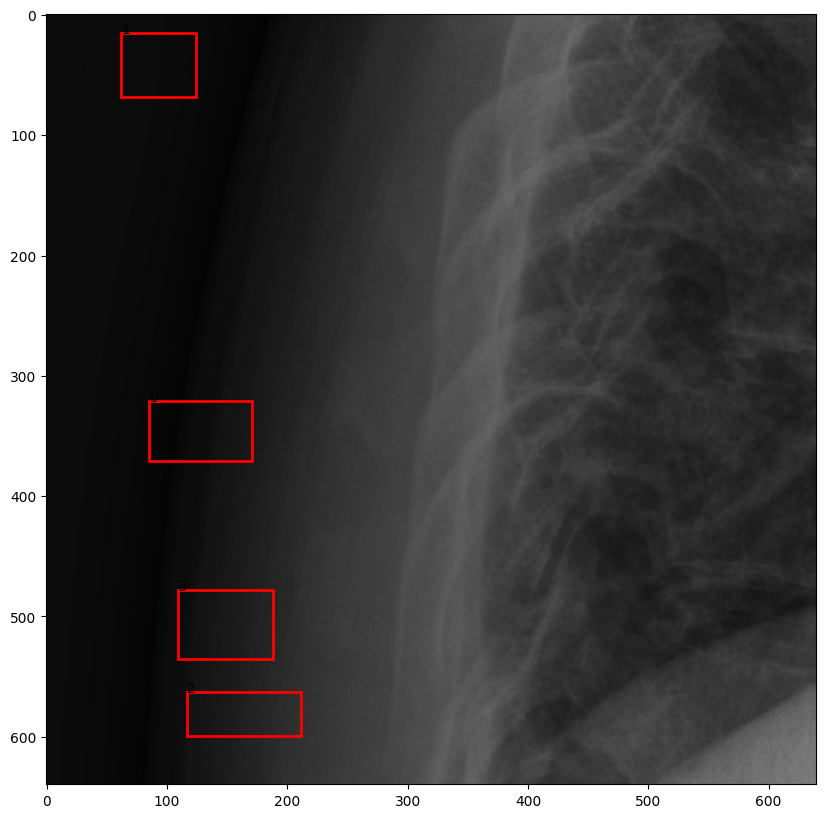

imagen0-10.jpg


<Figure size 640x480 with 0 Axes>

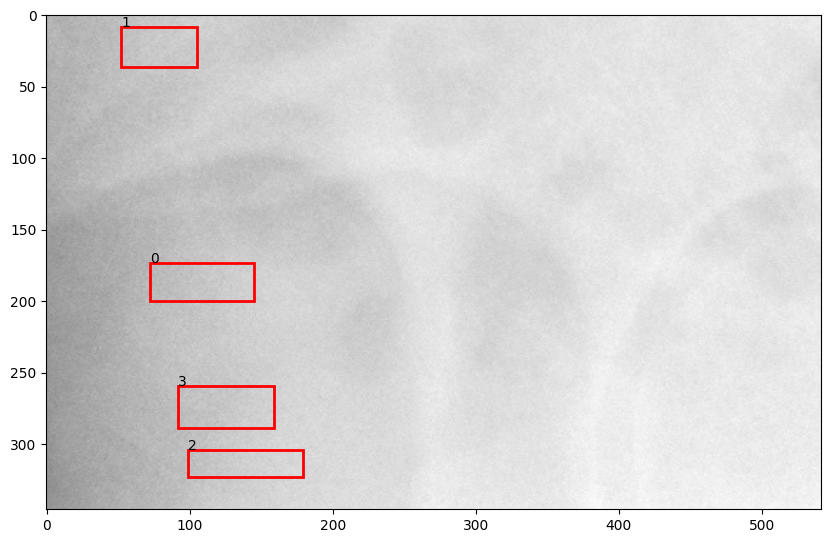

imagen0-2.jpg


<Figure size 640x480 with 0 Axes>

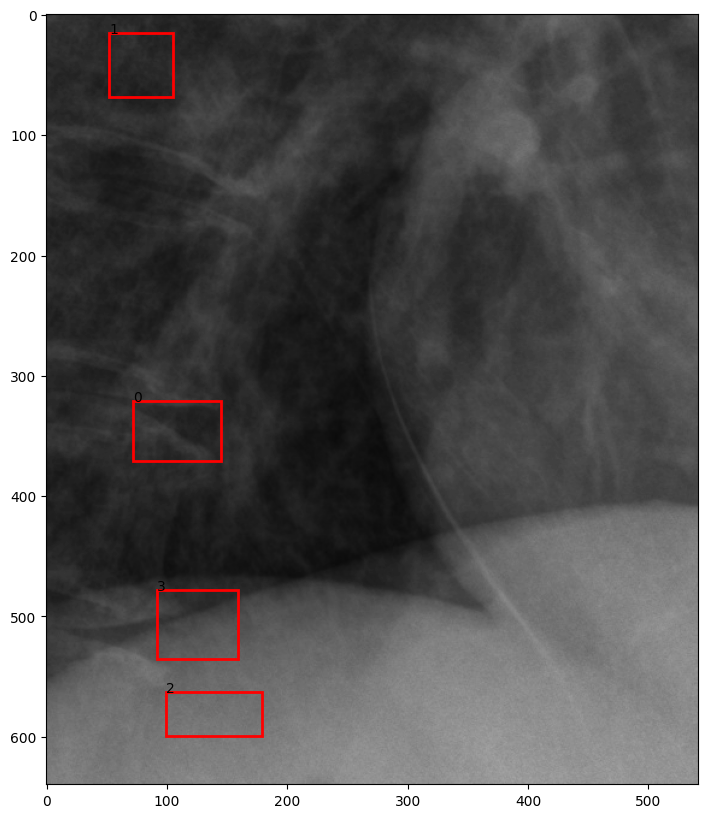

imagen0-3.jpg


<Figure size 640x480 with 0 Axes>

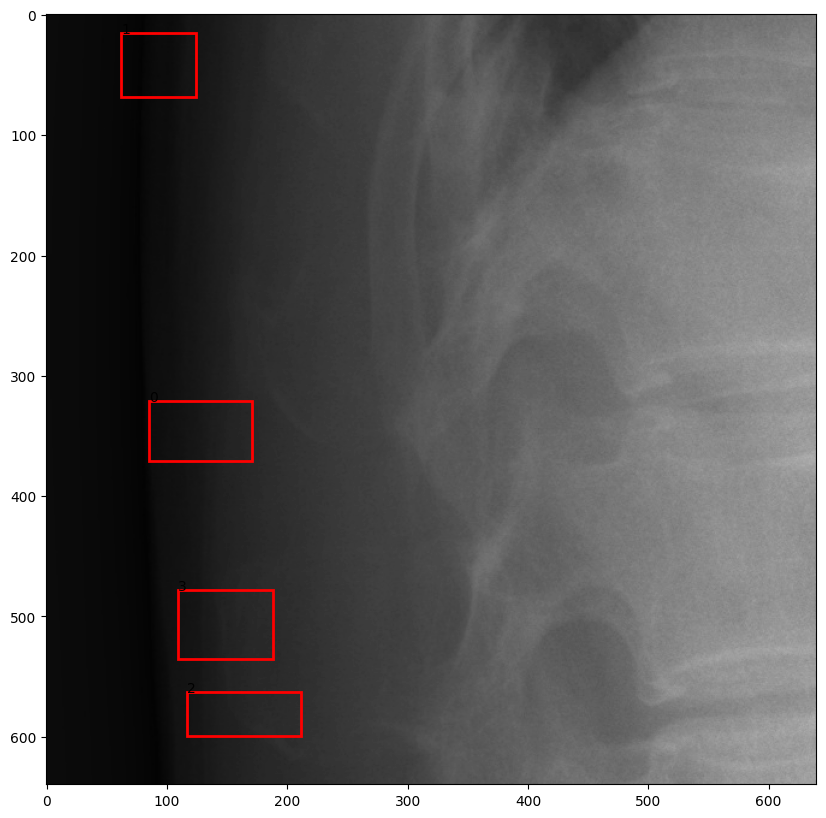

imagen0-4.jpg


<Figure size 640x480 with 0 Axes>

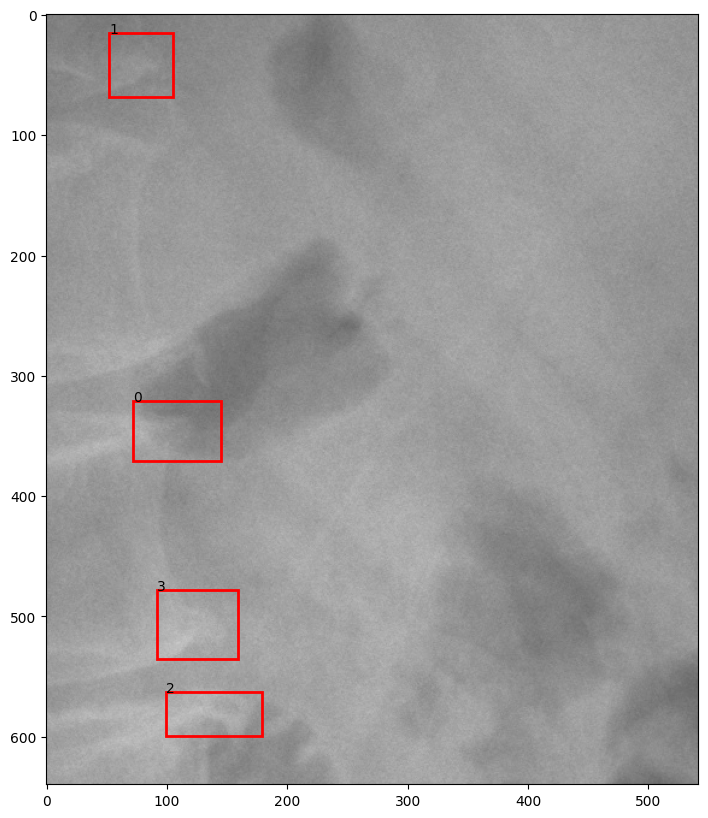

imagen0-5.jpg


<Figure size 640x480 with 0 Axes>

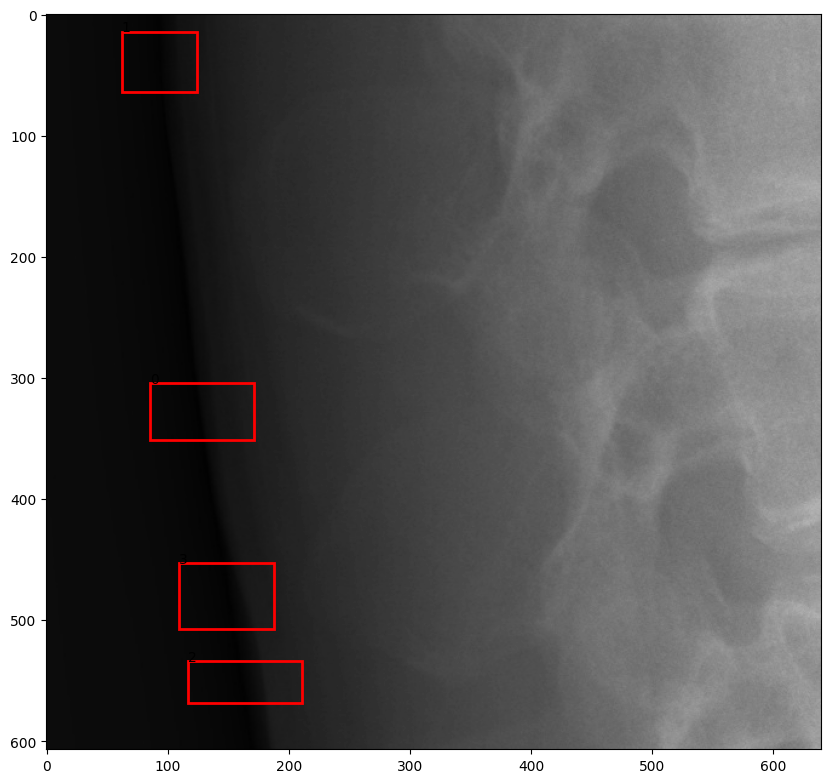

imagen0-6.jpg


<Figure size 640x480 with 0 Axes>

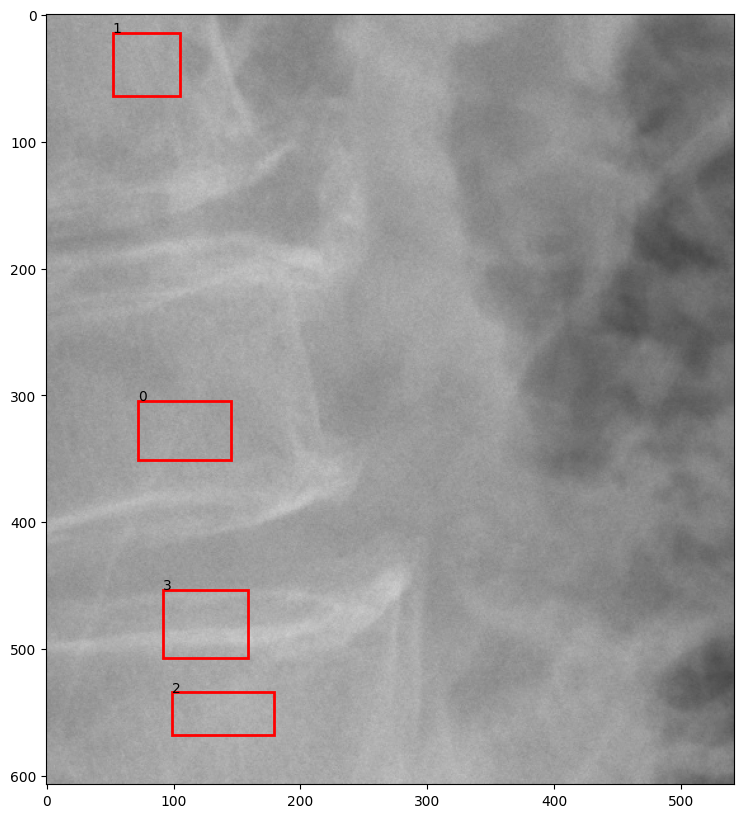

imagen0-7.jpg


<Figure size 640x480 with 0 Axes>

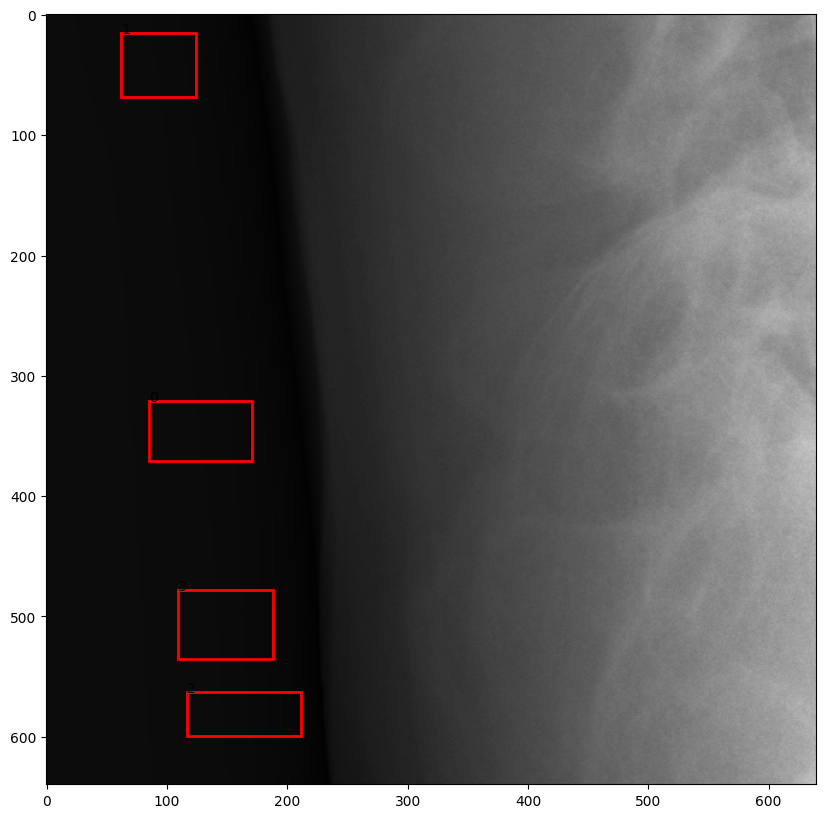

imagen0-8.jpg


<Figure size 640x480 with 0 Axes>

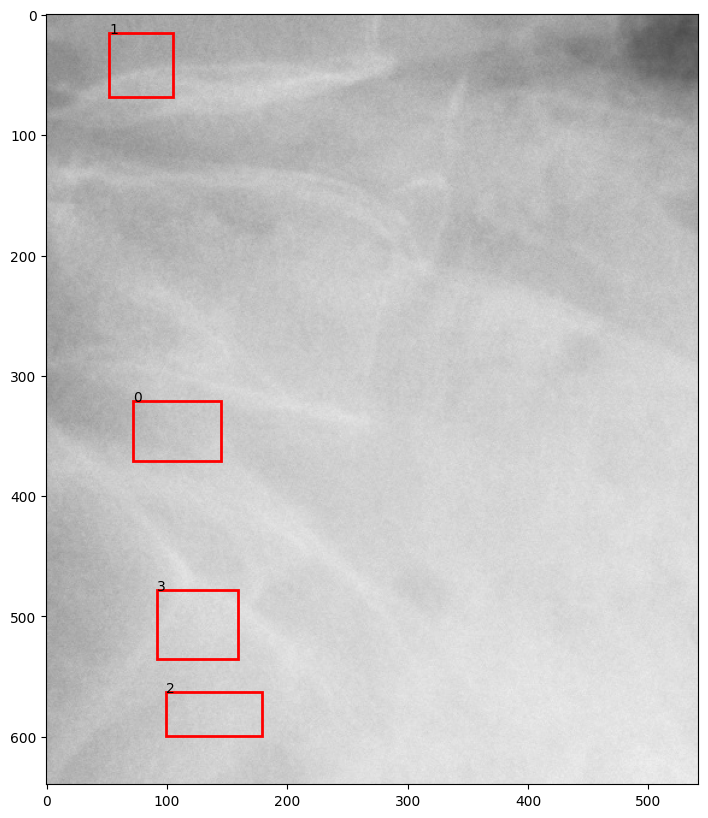

imagen0-9.jpg


<Figure size 640x480 with 0 Axes>

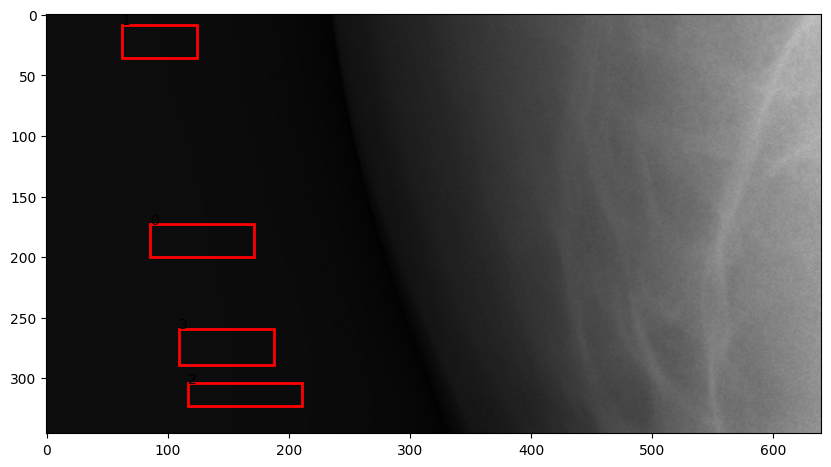

In [ ]:
# Cargar imagen y graficar las nuevas\
for Num_img in range(0, 10):
  Path="/content/drive/MyDrive/Trabajo_final_VIU/Resources/Train/images/"
  img,imagen_id = Cargar_imagen(Num_img,Path,Lista_imagenes)
  print(imagen_id)
  plt.subplot(5, 2, Num_img+1)
  Graficar(img,Data)

In [ ]:
BASE_FOLDER = "/content/drive/MyDrive/Trabajo_final_VIU/Resources/Train/"
Lista = os.listdir(BASE_FOLDER+'labels/')
print(len(Lista))
display( 'imagen1-1.txt' in Lista)

#Test dataset


In [ ]:
badlisttest=[30,31,32,33,45,52,
70,81,80,92,188,187,193,204,224,222,249,243,248,244,240,239,247,
267,266,274,277,283,305,313,449,443,465,466,468,467,
477,478,480,479,482,483,486,487,488,489,495,497,508,
513,521,522,523,520,517,518,519,531,535,529,528,524,
539,540,542,600,608,618,764,
794,786,787,792,813,825,839,841,844,845,
848,852,865,871,870,928,937,936,933,938,
946,952,978,976,973,982,981,989,993,
999,997,1029,1026,1025,1024,1033,1056,
1150,1188,1181,1178,1177,1180,1187,1191,1197,1196,1164,1200,1189,
1221,1220,1239,1240,1245,1309,1310,1313,1312,1325,1335,1358,1365,1363,
1380,1381,1407,1422,1417,1421,1420,1434,1432,1433,1443,1463,1469,1468,
1470,1475,1476,1482,1549,1563,1573,1671,
1681,1682,1674,1676,1690,1683,1703,1699,1705,
1743,1751,1755,1789,1791,1794,1862,1859,
1903,1901,1906,1947,1948,1951,
1952,1960,1971,1968,1984,2041,2056,2058,2056,
2073,2093,2103,2119,2127,2130,2133,2134,2183,2180,
2186,2187,2207,2203,2253,2298,2294,2340,2338,2341,2336,
2350,2363,2364,2391,2394,2395,2396,2419,
2434,2556,2566,2569,2601,2602,2600,
2624,2638,2640,2648,2656,2661,2660,2666,
2672,26710,2678,2677,2701,2696,2733,2734,2741,2762,
2779,2799,2807,2813,7827,2927,2938,2934,2930,2957,
2959,2975,2977,2976,2991,3026,
3056,3057,3062,3063,3064,3074,3088,3098,
3106,3104,3102,3101,3108,3126,3128,
3133,3134,3149,3147,3157,3173,3235,3258,3253,
3263,3277,3278,3274,3275,3306,3331,3335,3334,3349,
3353,3365,3366,3384,3383,3411,3406,3410,3408,
3415,3425,3431,3433,3457,3454,3459,3452,3460,
3536,3538,3539,3580,3581,3602,3643,3647,3663,3658,3660,
3669,3686,3692,3695,3712,3724,3727,3728,3732,3733,
3737,3766,3768,3778,3780,3788,3788,3799,3811,3812,3836,
3873,3880,3909,3910,3911,3912,3913,3943,3942,3953,3958,3964,3957,
3978,4005,4058,4059,4077,4080,4081,4086,4098,4153,4160,4167,4177,4188,4189,4190,
4217,4216,4228,4235,4244,4258,4273,4276,4306,4357,4356,4367,4492,4493,4499,4525,
4589,4586,4591,4592,4685,4699,4705,4709,4710,4712,4711,4713,4714,4718,4726,4727,4735,4740]

In [ ]:
BASE_FOLDER = "/content/drive/MyDrive/Trabajo_final_VIU/Resources/Test_Images/"
Lista = os.listdir(BASE_FOLDER)
print(len(Lista))
display( 'imagen1-1.txt' in Lista)

2077


False

In [ ]:
# Creacion Data Frame
cortes_test = pd.DataFrame(columns=['Nom_Img', 'Nom_Test', 'Width_Img','Heigt_Img','LineH','LineV'],index=range(878))
cortes_test.shape

(878, 6)

In [ ]:
def Cargar_imagen(Num_img):
  Test_image_dir = '/content/drive/MyDrive/Trabajo_final_VIU/Resources/Test_Images'
  img=cv2.imread(os.path.join(Test_image_dir, test_list[Num_img]+'.jpg'))
  img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  imagen_id=test_list[Num_img]
  mask=(test_csv["image_id"]==imagen_id)
  df=test_csv[mask]
  return(img,imagen_id,df)

In [ ]:
def Graficar(img,df,LineH,LineV,opc):

  # Imagen Principal
  plt.clf()
  fig, ax = plt.subplots()
  final_image = Image.fromarray(img)
  # Impresión con escala para mejor visualizacion
  fig.set_size_inches(20, 20, forward=True)
  ax.imshow(final_image, cmap='gray', vmin=0, vmax=255)
  #
  #dibujar puntos de enfermedad
  for i in df.index:
      # Create a Rectangle patch
      Width= int(df["xmax"][i]-df["xmin"][i])
      Height=int(df["ymax"][i]-df["ymin"][i])
#     Ver Imagen con Restricciones
      if (opc==1):
        if not(i in badlisttest):
          rect = patches.Rectangle((int(df["xmin"][i]), int(df["ymin"][i])), Width, Height, linewidth=2, edgecolor='r', facecolor='none')
          print(i,(int(df["xmin"][i]),int(df["ymin"][i]),Width,Height))
          plt.text(int(df["xmin"][i]), int(df["ymin"][i]),str(i))
          ax.add_patch(rect)
      else:
        # Ver imagen normal sin restricciones
        rect = patches.Rectangle((int(df["xmin"][i]), int(df["ymin"][i])), Width, Height, linewidth=2, edgecolor='r', facecolor='none')
        plt.text(int(df["xmin"][i]), int(df["ymin"][i]),str(i))
        ax.add_patch(rect)


  #Lineas de Corte
  for n in LineH:
    plt.axhline(y=n, color="g")
  for n in LineV:
    plt.axvline(x=n, color="g")

  plt.show()

In [ ]:
def Creacion_Lineas(Num_img,img,df,Stdar):
  img_height,img_width=np.array(img).shape[0],np.array(img).shape[1]
  NLineasy=img_height//Stdar
  Nlineasx=img_width//Stdar
  print(NLineasy," ",Nlineasx)

  LineH=[0]

  for n in range(1,NLineasy+1):
    LineH.append(n*640)
  print(LineH)
  n=0
  while (n<(len(LineH))):
    print(n)
    for i in df.index:
      if((df["ymin"][i]<=LineH[n])and(LineH[n]<=df["ymax"][i])) and not(i in badlisttest):
        LineH[n]=int(df["ymin"][i])-5
        for j in range(n+1,len(LineH)):
          LineH[j]=LineH[j-1]+640
        n=n-1
        print(LineH)
      if(img_height-LineH[-1]>640):
        LineH.append(LineH[-1]+640)
    n+=1
  if(LineH[-1]!=img_height-1):
    LineH.append(img_height-1)
  print(LineH)


  LineV=[0]
  for n in range(1,Nlineasx+1):
    LineV.append(n*640)
  print(LineV)

  n=0
  while (n<(len(LineV))):
    print(n)
    for i in df.index:
      if((df["xmin"][i]<=LineV[n])and(LineV[n]<=df["xmax"][i]))and not(i in badlisttest):
        LineV[n]=int(df["xmin"][i])-2
        for j in range(n+1,len(LineV)):
          LineV[j]=LineV[j-1]+640
        n=n-1
        print(LineV)
    if(img_width-LineV[-1]>640):
      LineV.append(LineV[-1]+640)
    n+=1
  if(LineV[-1]!=img_width-1):
    LineV.append(img_width-1)
  print(LineV)

  # Añadir al cvs
  cortes_test.loc[Num_img] = [train_list[Num_img],'imagen'+str(Num_img),img_width,img_height,LineH,LineV]
  # print(cortes_train.loc[Num_img])
  save_path = path.join('/content/drive/MyDrive/Trabajo_final_VIU/Resources/Annotations','TFM_test_cortes.csv')
  pd.DataFrame(cortes_test).to_csv(save_path)
  # display(cortes_train)
  # display(cortes_train.columns)

  return(LineH,LineV)

In [ ]:
# generar imagen y recortes
import matplotlib.patches as patches
import matplotlib.pylab as plt
from PIL import Image
#sacar las cajas de la imagen
for Num_img in range(0,len(test_list)):
# Num_img=1
  print(Num_img)
  img,imagen_id,df = Cargar_imagen(Num_img)
  LineH,LineV = Creacion_Lineas(Num_img,img,df,640)
  # Graficar(img,df,LineH,LineV,1)

0
4   1
[0, 640, 1280, 1920, 2560]
0
1
2
3
4
[0, 640, 1280, 1920, 2560, 2999]
[0, 640]
0
1
[0, 640, 1242]


NameError: ignored

#Crop de imagenes solo entranamiento


In [ ]:
import pandas as pd
from os import path

In [ ]:
# Leer el Data Frame
read_path = path.join('/content/drive/MyDrive/Trabajo_final_VIU/Resources/Annotations','TFM_test_cortes.csv')
cortes_test = pd.read_csv(read_path, index_col=[0])
print(cortes_test)

                              Nom_Img   Nom_Test  Width_Img  Heigt_Img  \
0    1f1c5c098c35b79052596aae08ac727f    imagen0       1243       3000   
1    9f4fb4f51315715cf1048fcc2f7d6f47    imagen1       1183       1563   
2    ba051e7ff54cce985012251b45f3e17f    imagen2       2212       2874   
3    3bb3235634a304d102d334e962328612    imagen3       1195       2874   
4    276615e32daf16ea56813ce30976817f    imagen4       1248       2874   
..                                ...        ...        ...        ...   
873  928e105341d59079eac7980e371dc178  imagen873       1198       2874   
874  ec2ec75bbf7a299ae77dcec69c24cab5  imagen874       1124       2874   
875  153df4b9136ec931bec915a8f6b23545  imagen875       1198       2874   
876  2d3a885f9efcadec7b287a2096bc6bfc  imagen876       1124       2874   
877  ba12601cf9cd671f64ed738343b1cba1  imagen877       1172       1527   

                                LineH                       LineV  
0    [0, 640, 1280, 1920, 2560, 2999]      

In [ ]:
# Recorte de Imagenes y Creacion de Test
# Crop
# #sacar las cajas de la imagen
def Crop_img2 (Num_img,img,df,LineH,LineV):
  # print("Imagen "+str(Num_img))
  # print(LineH)
  # print(LineV)
  global contar
  h=0
  cont=1
  while (h<(len(LineH)-1)):
    v=0
    while (v<(len(LineV)-1)):
      y1=int(LineH[h])
      y2=int(LineH[h+1])
      x1=int(LineV[v])
      x2=int(LineV[v+1])
      # print(str(y1)+" "+str(y2)+" "+str(x1)+" "+str(x2))
      Imagen2=[]
      Aux=""

      for i in df.index:
        Xcenter=int((df["xmax"][i]+df["xmin"][i])/(2))
        Ycenter=int((df["ymax"][i]+df["ymin"][i])/(2))
        Width= int(df["xmax"][i]-df["xmin"][i])
        Height=int(df["ymax"][i]-df["ymin"][i])
        if(((y1<=Ycenter)and(Ycenter<=y2)) and ((x1<=Xcenter)and(Xcenter<=x2))):
          if not(i in badlisttest):
            Aux=Aux+str("0"+" "+str((Xcenter-x1)/(x2-x1))+" "+str((Ycenter-y1)/(y2-y1))+" "+str(Width/(x2-x1))+" "+str(Height/(y2-y1))+ "\n")
      #Impresión en TXT
      if not (Aux==""):
        path="/content/drive/MyDrive/Trabajo_final_VIU/YOLOV8/Dataset/test/"+"/labels/"
        isExist = os.path.exists(path)
        if not isExist:
          os.makedirs(path)
        # print(str(h)+" "+str(v))
        # print("imagen"+str(j)+"-"+str(cont))
        # print(Aux)
        with open(path+"imagen"+str(Num_img)+"-"+str(cont)+".txt", 'w') as txt_file:
          txt_file.write(str(Aux))

        Imagen2 = img[y1:y2,x1:x2]
        # display(Imagen2)
        path="/content/drive/MyDrive/Trabajo_final_VIU/YOLOV8/Dataset/test/"+"/images/"
        isExist = os.path.exists(path)
        if not isExist:
          os.makedirs(path)
        destination= path +"imagen"+str(Num_img)+"-"+str(cont)+'.jpg'
        # print(contar)
        cv2.imwrite(destination, Imagen2)
        contar+=1
      cont+=1
      v+=1
    h+=1

In [ ]:
#Crop de las imagenes
LineHcsv=np.array(cortes_test["LineH"])
LineVcsv=np.array(cortes_test["LineV"])
contar=0

for Num_img in range(0,len(test_list)):
  img,imagen_id,df = Cargar_imagen(Num_img)
  # Graficar(img,df,LineH,LineV,1)  #df son los puntos que nos entrega el Csv original: 0 para ver todos los puntos; 1 para ver solo los puntos correctos
  LineH=LineHcsv[Num_img][1:-1].split(", ")
  LineV=LineVcsv[Num_img][1:-1].split(", ")
  Crop_img2(Num_img,img,df,LineH,LineV)
print(contar)

1664


In [ ]:
import os
import numpy as np
BASE_FOLDER="/content/drive/MyDrive/Trabajo_final_VIU/YOLOV8/Dataset/test/"
Lista_imagenes = os.listdir(BASE_FOLDER+'images/')
Lista_imagenes.sort()
print(len(Lista_imagenes))


1664
